Ce notebook va servir à la création de notre vecteur Y et notre tableau X de 2006 à 2022 sur la saison estivale afin d'appliquer ensuite nos modèles de prédiction.

In [17]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point

In [10]:
!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 3.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.3/411.3 kB 18.9 MB/s eta 0:00:00
  Cloning https://github.com/inseefrlab/cartiflette (to revision 80b8a5a28371feb6df31d55bcc2617948a5f9b1a) to /tmp/pip-req-build-yqr9sney
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-yqr9sney
  Running command git rev-parse -q --verify 'sha^80b8a5a28371feb6df31d55bcc2617948a5

In [11]:
import cartiflette.s3 as s3

## Base de données des communes des Landes ##

Pour avoir toutes les communes des Landes et pas uniquement celles présente dans BDIFF, on importe la base suivante

In [2]:
data_communes = 'Codes-INSEE-communes-geolocalisees.csv'

df_communes = pd.read_csv('Codes-INSEE-communes-geolocalisees.csv', encoding='ISO-8859-1')
#print(df_communes.head())

# Filtrer pour garder uniquement les communes des Landes (codes INSEE commençant par '40')
data_landes = df_communes[df_communes['Insee'].str.startswith('40')]
print(data_landes.head())

     Insee                    Nom  Altitude  code_postal  longitude_radian  \
1555  4001                 Aiglun     780.0         4510          0.106989   
1556  4004  Allemagne-en-Provence     420.0  04550|04500          0.104851   
1557  4005                 Allons    1073.0         4170          0.115095   
1558  4006                  Allos    1414.0         4260          0.115652   
1559  4007                 Angles     961.0         4170          0.114445   

      latitude_radian  pop99  surface  
1555         0.769070   1038    14.58  
1556         0.764158    379    33.18  
1557         0.767567     81    41.96  
1558         0.772177    637   117.31  
1559         0.766970     67    10.02  


## Création du vecteur Y ##

Y est un vecteur de 0 et de 1. Chaque ligne correspond à une commune, qui vont être répétées de 2006 à 2022 :
- $Y_1$ = 1 si il y a eu au moins un feu dans la commune 1 sur la période estivale en 2006, 0 sinon
- $Y_2$ = 1 si il y a eu au moins un feu dans la commune 2 sur la période estivale en 2006, 0 sinon
  ...

In [4]:
data = 'combine.csv'

df = pd.read_csv('combine.csv', sep=';')
#print(df.head())

# Pour les Landes
bdiff_landes = df[df['Département'] == '40']
print(bdiff_landes.head())

     Année  Numéro Département Code INSEE  Nom de la commune  \
652   2006    1876          40      40006          Arengosse   
653   2006    1877          40      40151             Lesgor   
654   2006    1878          40      40108             Gastes   
655   2006    1879          40      40210  Onesse-et-Laharie   
656   2006    1881          40      40167              Luxey   

    Date de première alerte Origine de l'alerte  \
652        26/07/2006 19:40         Indéterminé   
653        17/07/2006 15:29         Indéterminé   
654        25/04/2006 18:40         Indéterminé   
655        17/07/2006 18:20         Indéterminé   
656        27/07/2006 10:49         Indéterminé   

     Moyens de première intervention  Surface parcourue (m2)  \
652                              NaN                    5000   
653                              NaN                   66000   
654                              NaN                     400   
655                              NaN                

*Test uniquement pour l'année 2006*

In [5]:
# Conversion du format de la date
bdiff_landes.loc[:, 'Date de première alerte'] = pd.to_datetime(bdiff_landes['Date de première alerte'], format='%d/%m/%Y %H:%M')

# Filtrer pour l'été 2006
bdiff_landes_2006 = bdiff_landes[bdiff_landes['Année'] == 2006]
df_summer = bdiff_landes_2006[bdiff_landes_2006['Date de première alerte'].dt.month.isin([6, 7, 8])]

# Aggrégation par commune avec vérification des incendies
feu_par_commune = df_summer.groupby('Code INSEE').size().gt(0).reset_index(name='Feu en été')

# Convertir les valeurs en 1 et 0
feu_par_commune['Feu en été'] = feu_par_commune['Feu en été'].astype(int)

# Liste complète des communes des Landes
communes_landes = data_landes[['Insee']].rename(columns={'Insee': 'Code INSEE'})

# Jointure avec la liste des communes des Landes pour inclure toutes les communes
Y = communes_landes.merge(feu_par_commune, on='Code INSEE', how='left')
Y['Feu en été'] = Y['Feu en été'].fillna(0).astype(int)

print(Y)

AttributeError: Can only use .dt accessor with datetimelike values

*De 2006 à 2022, avec toutes les communes*

In [6]:
data_communes = 'Codes-INSEE-communes-geolocalisees.csv'
df_communes = pd.read_csv('Codes-INSEE-communes-geolocalisees.csv', encoding='ISO-8859-1')
data_landes = df_communes[df_communes['Insee'].str.startswith('40')]
data = 'combine.csv'
df = pd.read_csv('combine.csv', sep=';')
bdiff_landes = df[df['Département'] == '40']
bdiff_landes['Date de première alerte'] = pd.to_datetime(bdiff_landes['Date de première alerte'], format='%d/%m/%Y %H:%M')
communes_landes = data_landes[['Insee']].rename(columns={'Insee': 'Code INSEE'})

# Initialisation du DataFrame final
Y = pd.DataFrame()

annees = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2022]

for annee in annees:
    df_annee = bdiff_landes[bdiff_landes['Année'] == annee]
    df_summer = df_annee[df_annee['Date de première alerte'].dt.month.isin([6, 7, 8])]
    feu_par_commune = df_summer.groupby('Code INSEE').size().gt(0).reset_index(name='Feu en été')
    feu_par_commune['Feu en été'] = feu_par_commune['Feu en été'].astype(int)
    resultat_annuel = communes_landes.merge(feu_par_commune, on='Code INSEE', how='left')
    resultat_annuel['Feu en été'] = resultat_annuel['Feu en été'].fillna(0).astype(int)
    resultat_annuel['Année'] = annee  # Ajout de la colonne Année
    Y = pd.concat([Y, resultat_annuel], ignore_index=True)

print(Y)

     Code INSEE  Feu en été  Année
0          4001           0   2006
1          4004           0   2006
2          4005           0   2006
3          4006           0   2006
4          4007           0   2006
...         ...         ...    ...
6539      40330           0   2022
6540      40331           1   2022
6541      40332           1   2022
6542      40333           0   2022
6543      40334           0   2022

[6544 rows x 3 columns]


/tmp/ipykernel_556/1352777133.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdiff_landes['Date de première alerte'] = pd.to_datetime(bdiff_landes['Date de première alerte'], format='%d/%m/%Y %H:%M')


## Correspondance commune / maille ##

Afin de pouvoir manipuler les IFM (calculés au coin de chaque maille), et le nombre de feu (connu par commune), et pouvoir ensuite faire nos régressions par maille, il faut arriver à trouver le lien entre les communes et les mailles.

Pour ça, nous avons à notre disposition la base maille_landes, correspondant aux mailles SAFRAN utilisés par le DRIAS pour calculer les IFM, et la base Codes-INSEE_communes, avec toutes les communes des Landes.

*Pour rappel, la base Codes-INSEE*

In [7]:
data_communes = 'Codes-INSEE-communes-geolocalisees.csv'

df_communes = pd.read_csv('Codes-INSEE-communes-geolocalisees.csv', encoding='ISO-8859-1')
#print(df_communes.head())

# Filtrer pour garder uniquement les communes des Landes (codes INSEE commençant par '40')
data_landes = df_communes[df_communes['Insee'].str.startswith('40')]
print(data_landes.head())

     Insee                    Nom  Altitude  code_postal  longitude_radian  \
1555  4001                 Aiglun     780.0         4510          0.106989   
1556  4004  Allemagne-en-Provence     420.0  04550|04500          0.104851   
1557  4005                 Allons    1073.0         4170          0.115095   
1558  4006                  Allos    1414.0         4260          0.115652   
1559  4007                 Angles     961.0         4170          0.114445   

      latitude_radian  pop99  surface  
1555         0.769070   1038    14.58  
1556         0.764158    379    33.18  
1557         0.767567     81    41.96  
1558         0.772177    637   117.31  
1559         0.766970     67    10.02  


*Et la base mailles_landes*

In [8]:
data_safran = 'mailles_landes.csv'

df_safran = pd.read_csv('mailles_landes.csv')
print(df_safran.head())

   Unnamed: 0  maille_safran  maille_drias   latitude  longitude  altitude  \
0        6585           7741          5895  44.447977  -1.229972        28   
1        6586           7742          5896  44.451195  -1.129639        23   
2        6587           7743          5897  44.454322  -1.029295        36   
3        6666           7823          5752  44.376109  -1.225422        28   
4        6667           7824          5753  44.379323  -1.125217        32   

   departement region_avant_2016          region2016          nature  ...  \
0  40 - Landes         Aquitaine  Nouvelle-Aquitaine  Limite côtière  ...   
1  40 - Landes         Aquitaine  Nouvelle-Aquitaine      Territoire  ...   
2  40 - Landes         Aquitaine  Nouvelle-Aquitaine      Territoire  ...   
3  40 - Landes         Aquitaine  Nouvelle-Aquitaine  Limite côtière  ...   
4  40 - Landes         Aquitaine  Nouvelle-Aquitaine      Territoire  ...   

   clc_311  clc_312  clc_313   rupro  rupromin  rupromax   pro   hpf

# But :
Dessiner la carte des communes des Landes en plaçant des points aux coordonnées latitude/longitude des deux bases afin de voir si ils coincident

In [13]:
## 1- télécharger la carte des communes

communes_landes = s3.download_vectorfile_url_all(
    values="40",  # Code département des Landes
    crs=4326,  
    borders="COMMUNE",  
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",  
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# Calcul de l'aire des communes en mètre carré (projection en Lambert-93)
communes_landes["area"] = communes_landes.to_crs(2154).area

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=40/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 1.12MiB [00:00, 17.0MiB/s]


In [16]:
## 2- convertir les coordonnées de la base insee en degré et non pas en radians

data_landes.loc[:, 'longitude_degrees'] = np.degrees(data_landes.loc[:, 'longitude_radian'])
data_landes.loc[:, 'latitude_degrees'] = np.degrees(data_landes.loc[:, 'latitude_radian'])

print(data_landes.head())

     Insee                    Nom  Altitude  code_postal  longitude_radian  \
1555  4001                 Aiglun     780.0         4510          0.106989   
1556  4004  Allemagne-en-Provence     420.0  04550|04500          0.104851   
1557  4005                 Allons    1073.0         4170          0.115095   
1558  4006                  Allos    1414.0         4260          0.115652   
1559  4007                 Angles     961.0         4170          0.114445   

      latitude_radian  pop99  surface  longitude_degrees  latitude_degrees  
1555         0.769070   1038    14.58           6.130000         44.064445  
1556         0.764158    379    33.18           6.007500         43.783054  
1557         0.767567     81    41.96           6.594444         43.978333  
1558         0.772177    637   117.31           6.626389         44.242500  
1559         0.766970     67    10.02           6.557222         43.944168  


In [20]:
## 3- conversion des GeoDataFrame

geometry_landes = [Point(xy) for xy in zip(data_landes['longitude_degrees'], data_landes['latitude_degrees'])]
geo_data_landes = gpd.GeoDataFrame(data_landes, geometry=geometry_landes)

geometry_safran = [Point(xy) for xy in zip(df_safran['longitude'], df_safran['latitude'])]
geo_df_safran = gpd.GeoDataFrame(df_safran, geometry=geometry_safran)

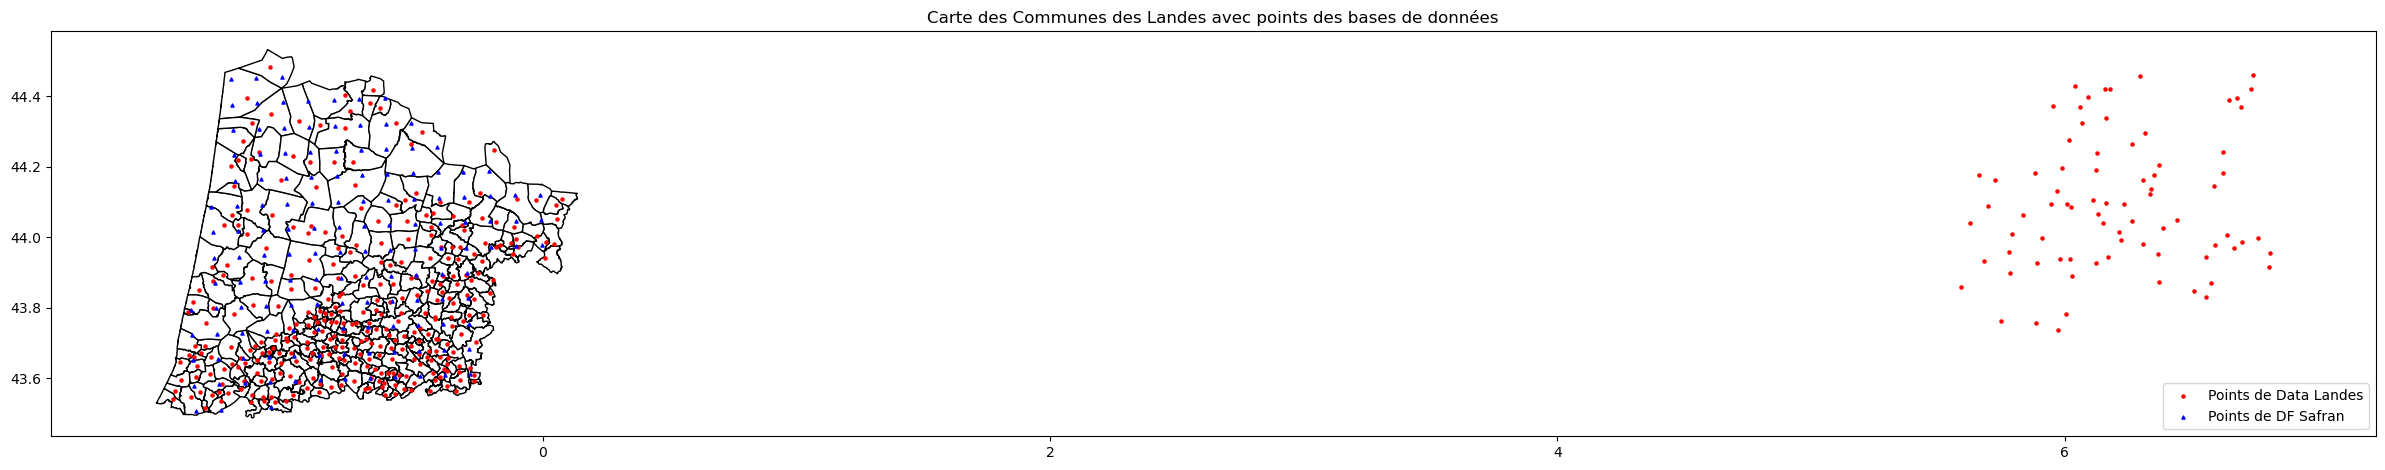

In [25]:
## 4- visualisation avec la shapeline des communes 

# Assurer que toutes les données sont dans le même système de coordonnées
geo_data_landes = geo_data_landes.set_crs(epsg=4326)  # WGS 84
geo_df_safran = geo_df_safran.set_crs(epsg=4326)  # WGS 84
communes_landes = communes_landes.to_crs(epsg=4326)  # Convertir si différent

fig, ax = plt.subplots(figsize=(30, 30))
communes_landes.plot(ax=ax, color='white', edgecolor='black')

# Ajouter les points de geo_data_landes et geo_df_safran à la carte
geo_data_landes.plot(ax=ax, marker='o', color='red', markersize=5, label='Points de Data Landes')
geo_df_safran.plot(ax=ax, marker='^', color='blue', markersize=5, label='Points de DF Safran')

plt.title('Carte des Communes des Landes avec points des bases de données')
plt.legend()

plt.show()


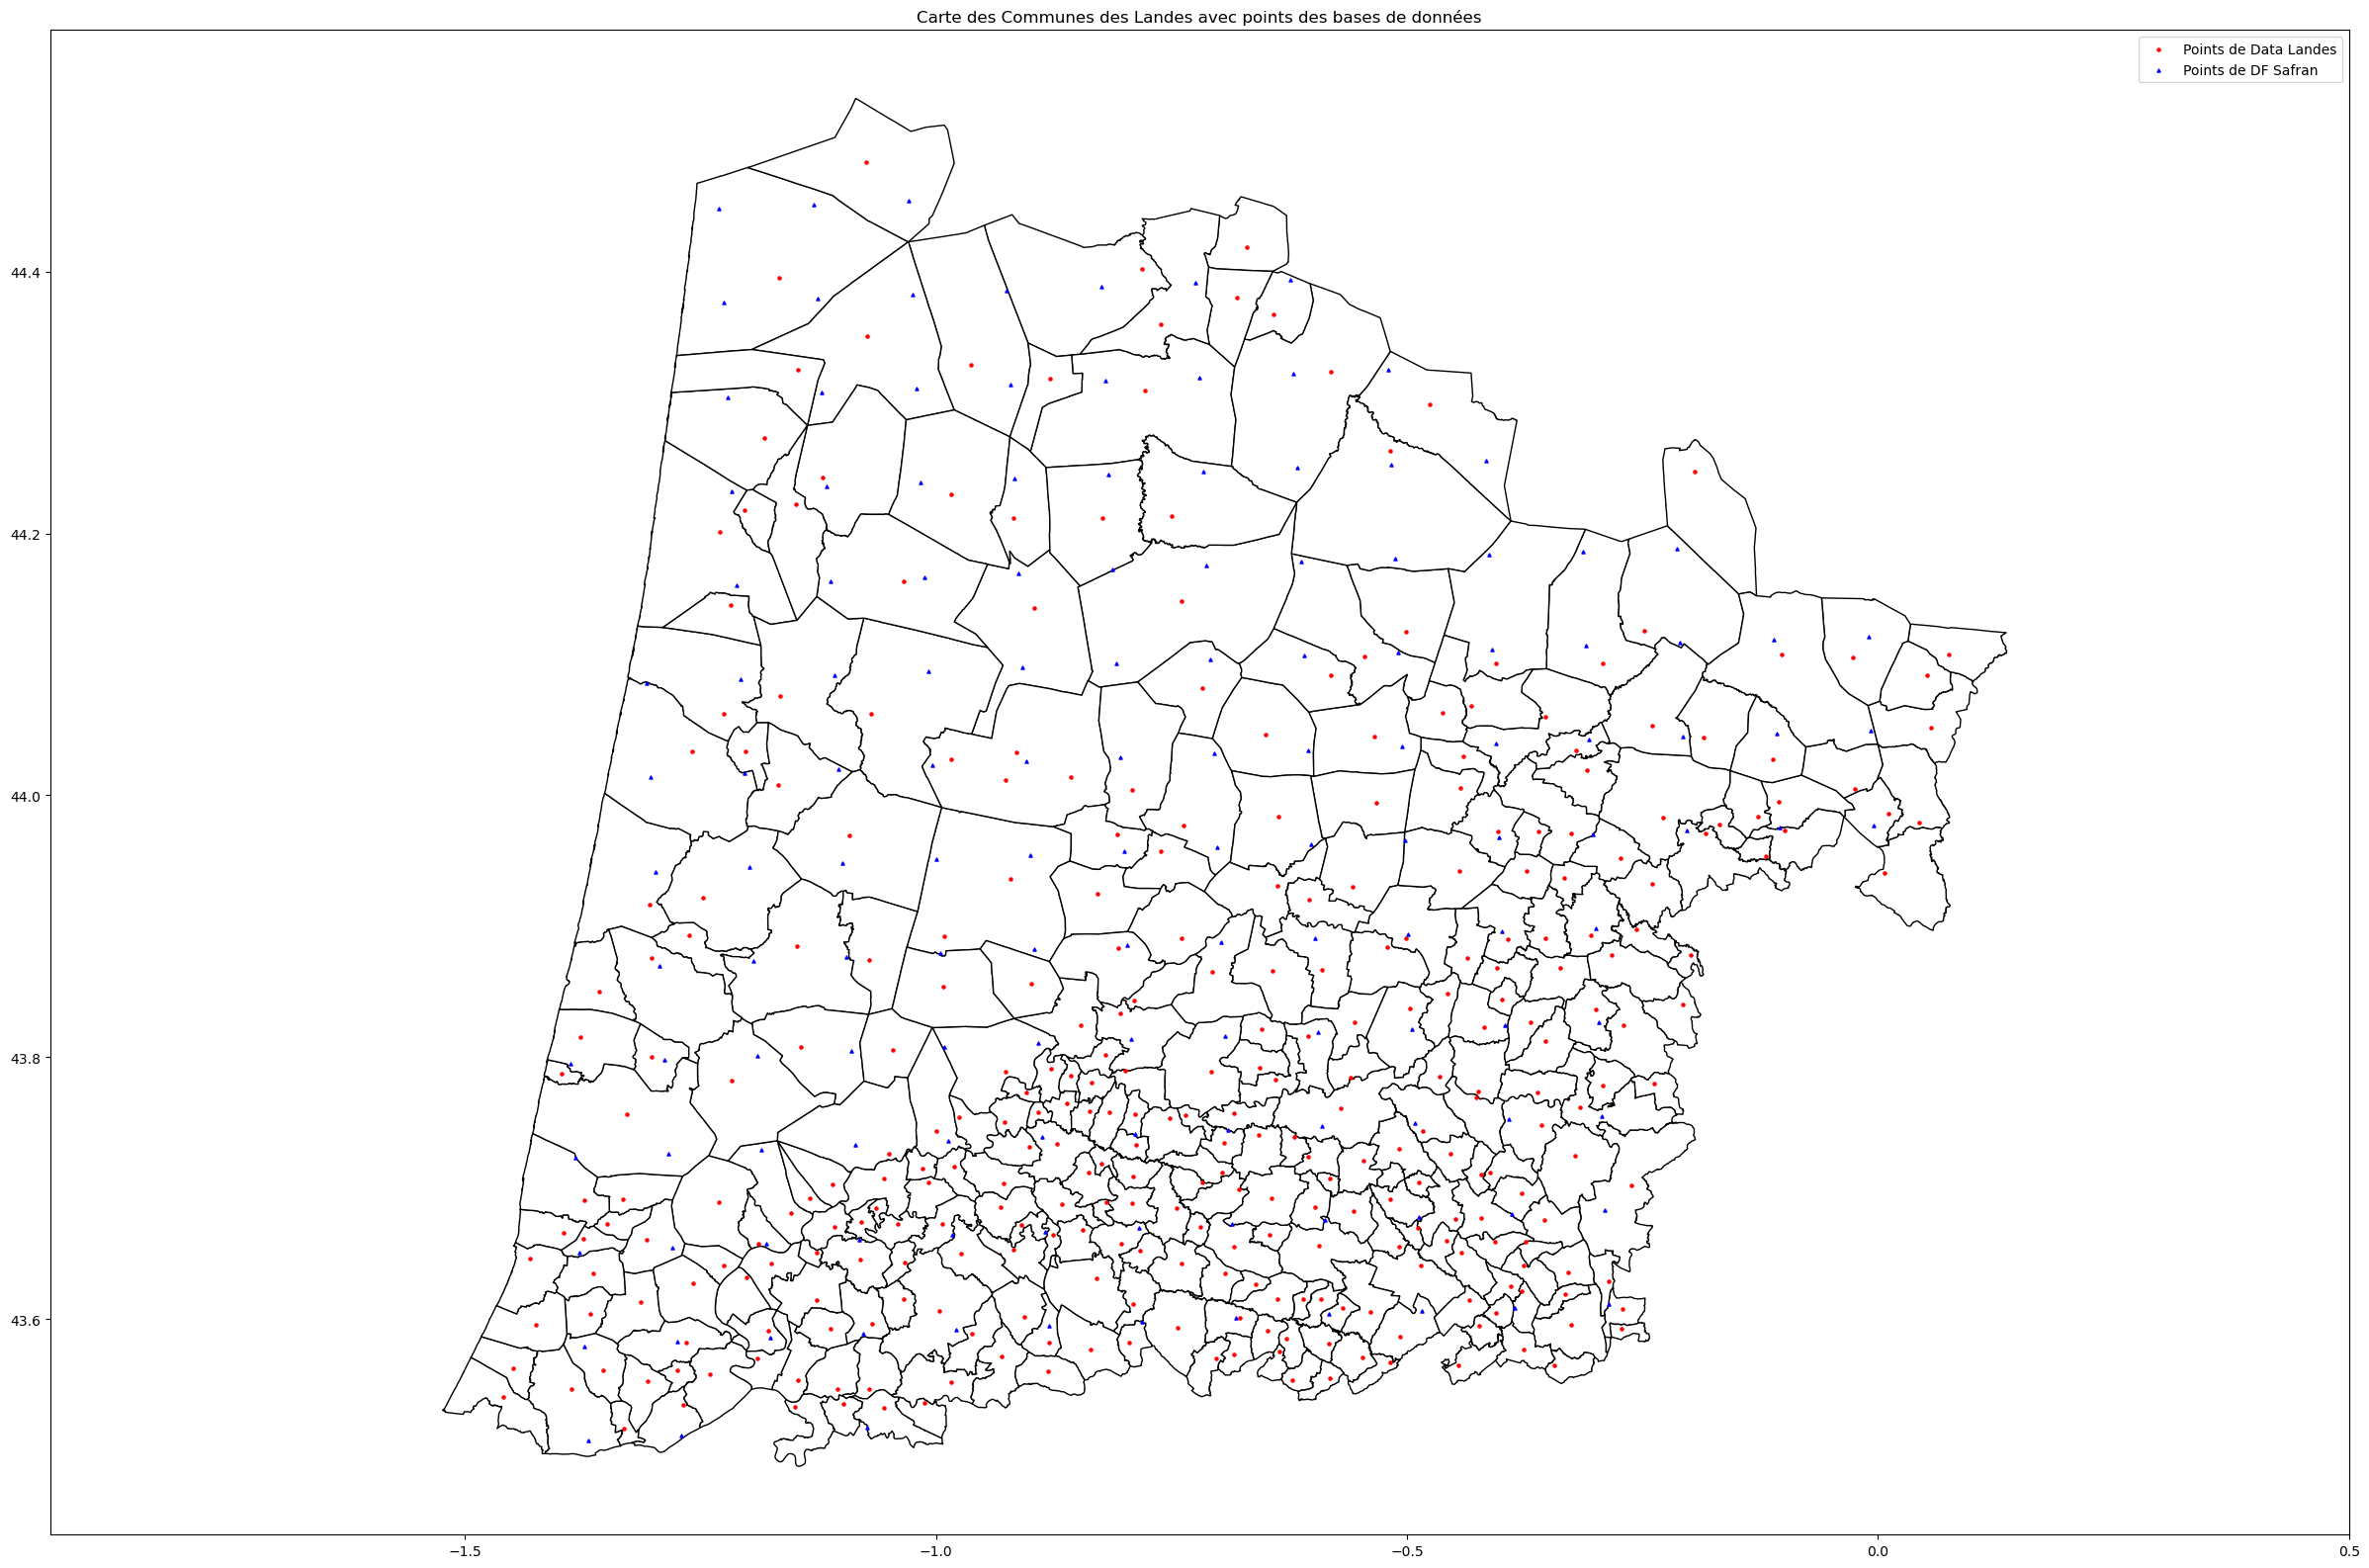

In [28]:
## 5- zoom sur la partie gauche

# Assurer que toutes les données sont dans le même système de coordonnées
geo_data_landes = geo_data_landes.set_crs(epsg=4326)  # WGS 84
geo_df_safran = geo_df_safran.set_crs(epsg=4326)  # WGS 84
communes_landes = communes_landes.to_crs(epsg=4326)  # Convertir si différent

fig, ax = plt.subplots(figsize=(30, 30))
communes_landes.plot(ax=ax, color='white', edgecolor='black')

# Ajouter les points de geo_data_landes et geo_df_safran à la carte
geo_data_landes.plot(ax=ax, marker='o', color='red', markersize=5, label='Points de Data Landes')
geo_df_safran.plot(ax=ax, marker='^', color='blue', markersize=5, label='Points de DF Safran')

ax.set_xlim(left=None, right=0.5)  

plt.title('Carte des Communes des Landes avec points des bases de données')
plt.legend()

plt.show()


On remarque que ça ne correspond pas bien.